In [1]:
import torch
import numpy as np
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import FieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5.5
n_thermalization_steps = 200
n_steps = 50
step_size = 0.1
n_iterations = 2048

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Set default type
torch.set_default_dtype(torch.float32)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Thermalizing:   0%|          | 0/200 [00:00<?, ?it/s]

Running HMC: 100%|██████████| 2048/2048 [00:23<00:00, 87.51it/s]


>>> Simulation completed


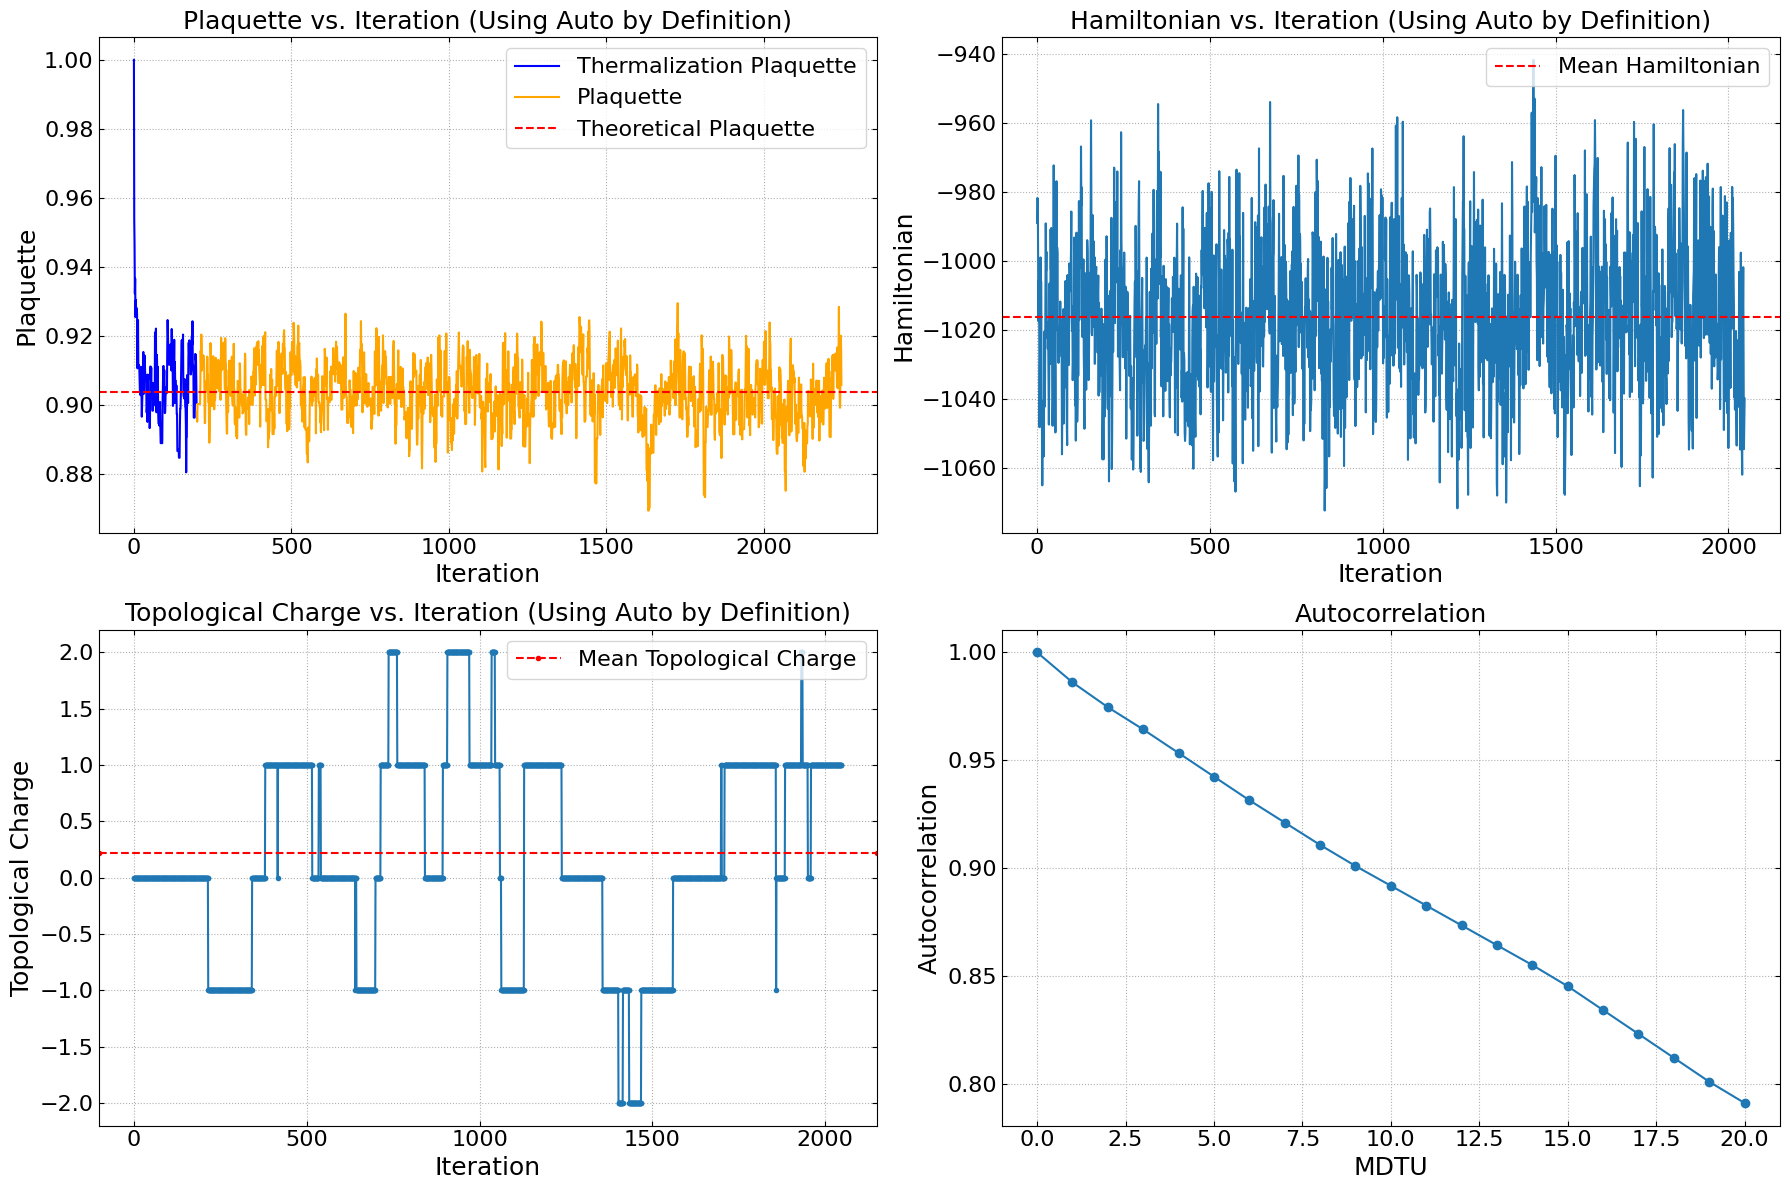

>>> Theoretical plaquette:  0.9038174337574352
>>> Mean plaq:  0.9033090094744693
>>> Std of mean plaq:  0.0001883548282514305
Thermalization acceptance rate: 0.7800
Acceptance rate: 0.7588


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

# Save configurations for training
np.save('dump/theta_ori.npy', torch.stack(config_ls).detach().cpu().numpy())


### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


/home/jinchen/miniconda3/envs/lat/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Loaded data shape: torch.Size([2048, 2, 16, 16])
Training data shape: torch.Size([1638, 2, 16, 16])
Testing data shape: torch.Size([410, 2, 16, 16])
>>> Training the model


Training epochs:   6%|▋         | 1/16 [00:55<13:56, 55.77s/it]

Epoch 1/16 - Train Loss: 5.765552 - Test Loss: 4.870880


Training epochs:  12%|█▎        | 2/16 [01:51<12:58, 55.57s/it]

Epoch 2/16 - Train Loss: 4.447555 - Test Loss: 4.298218


Training epochs:  19%|█▉        | 3/16 [02:46<12:01, 55.47s/it]

Epoch 3/16 - Train Loss: 4.184515 - Test Loss: 4.196919


Training epochs:  25%|██▌       | 4/16 [03:41<11:05, 55.45s/it]

Epoch 4/16 - Train Loss: 4.124054 - Test Loss: 4.159507


Training epochs:  31%|███▏      | 5/16 [04:37<10:09, 55.37s/it]

Epoch 5/16 - Train Loss: 4.096142 - Test Loss: 4.141213


Training epochs:  38%|███▊      | 6/16 [05:32<09:13, 55.34s/it]

Epoch 6/16 - Train Loss: 4.082686 - Test Loss: 4.129938


Training epochs:  44%|████▍     | 7/16 [06:27<08:17, 55.22s/it]

Epoch 7/16 - Train Loss: 4.074482 - Test Loss: 4.124629


Training epochs:  50%|█████     | 8/16 [07:23<07:23, 55.45s/it]

Epoch 8/16 - Train Loss: 4.069729 - Test Loss: 4.121816


Training epochs:  56%|█████▋    | 9/16 [08:19<06:29, 55.62s/it]

Epoch 9/16 - Train Loss: 4.066246 - Test Loss: 4.118599


Training epochs:  62%|██████▎   | 10/16 [09:15<05:33, 55.66s/it]

Epoch 10/16 - Train Loss: 4.063491 - Test Loss: 4.115053


Training epochs:  69%|██████▉   | 11/16 [10:10<04:38, 55.62s/it]

Epoch 11/16 - Train Loss: 4.062438 - Test Loss: 4.115060


Training epochs:  75%|███████▌  | 12/16 [11:06<03:42, 55.65s/it]

Epoch 12/16 - Train Loss: 4.061121 - Test Loss: 4.114889


Training epochs:  81%|████████▏ | 13/16 [12:02<02:47, 55.67s/it]

Epoch 13/16 - Train Loss: 4.059322 - Test Loss: 4.113299


Training epochs:  88%|████████▊ | 14/16 [12:58<01:51, 55.91s/it]

Epoch 14/16 - Train Loss: 4.057480 - Test Loss: 4.111452


Training epochs:  94%|█████████▍| 15/16 [13:54<00:56, 56.01s/it]

Epoch 15/16 - Train Loss: 4.057900 - Test Loss: 4.111069


Training epochs: 100%|██████████| 16/16 [14:50<00:00, 55.66s/it]


Epoch 16/16 - Train Loss: 4.057368 - Test Loss: 4.111555


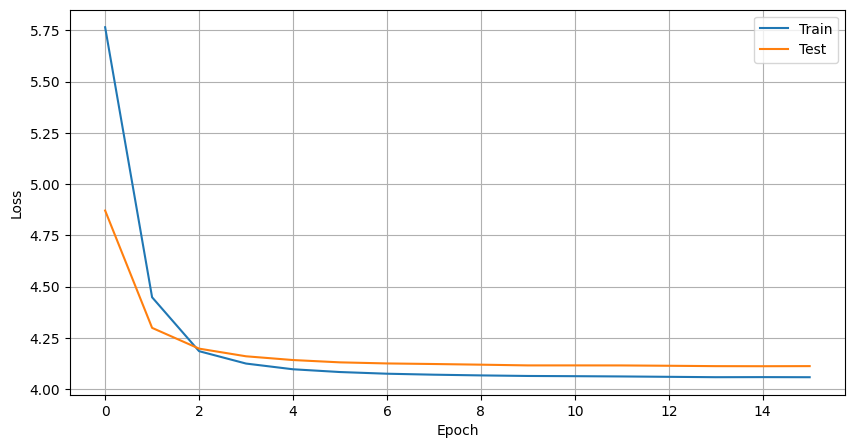

/home/jinchen/git/anl/hmc_ft/2d_u1_rep/cnn_model.py:352: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/best_model.pt')
/tmp/ipykernel_961502/

Loaded best models from epoch 14 with loss 4.111069
>>> Saving the trained models
>>> Models saved successfully
>>> Loading the trained models
>>> Models loaded successfully


Running HMC: 100%|██████████| 2048/2048 [24:30<00:00,  1.39it/s]


>>> Simulation completed


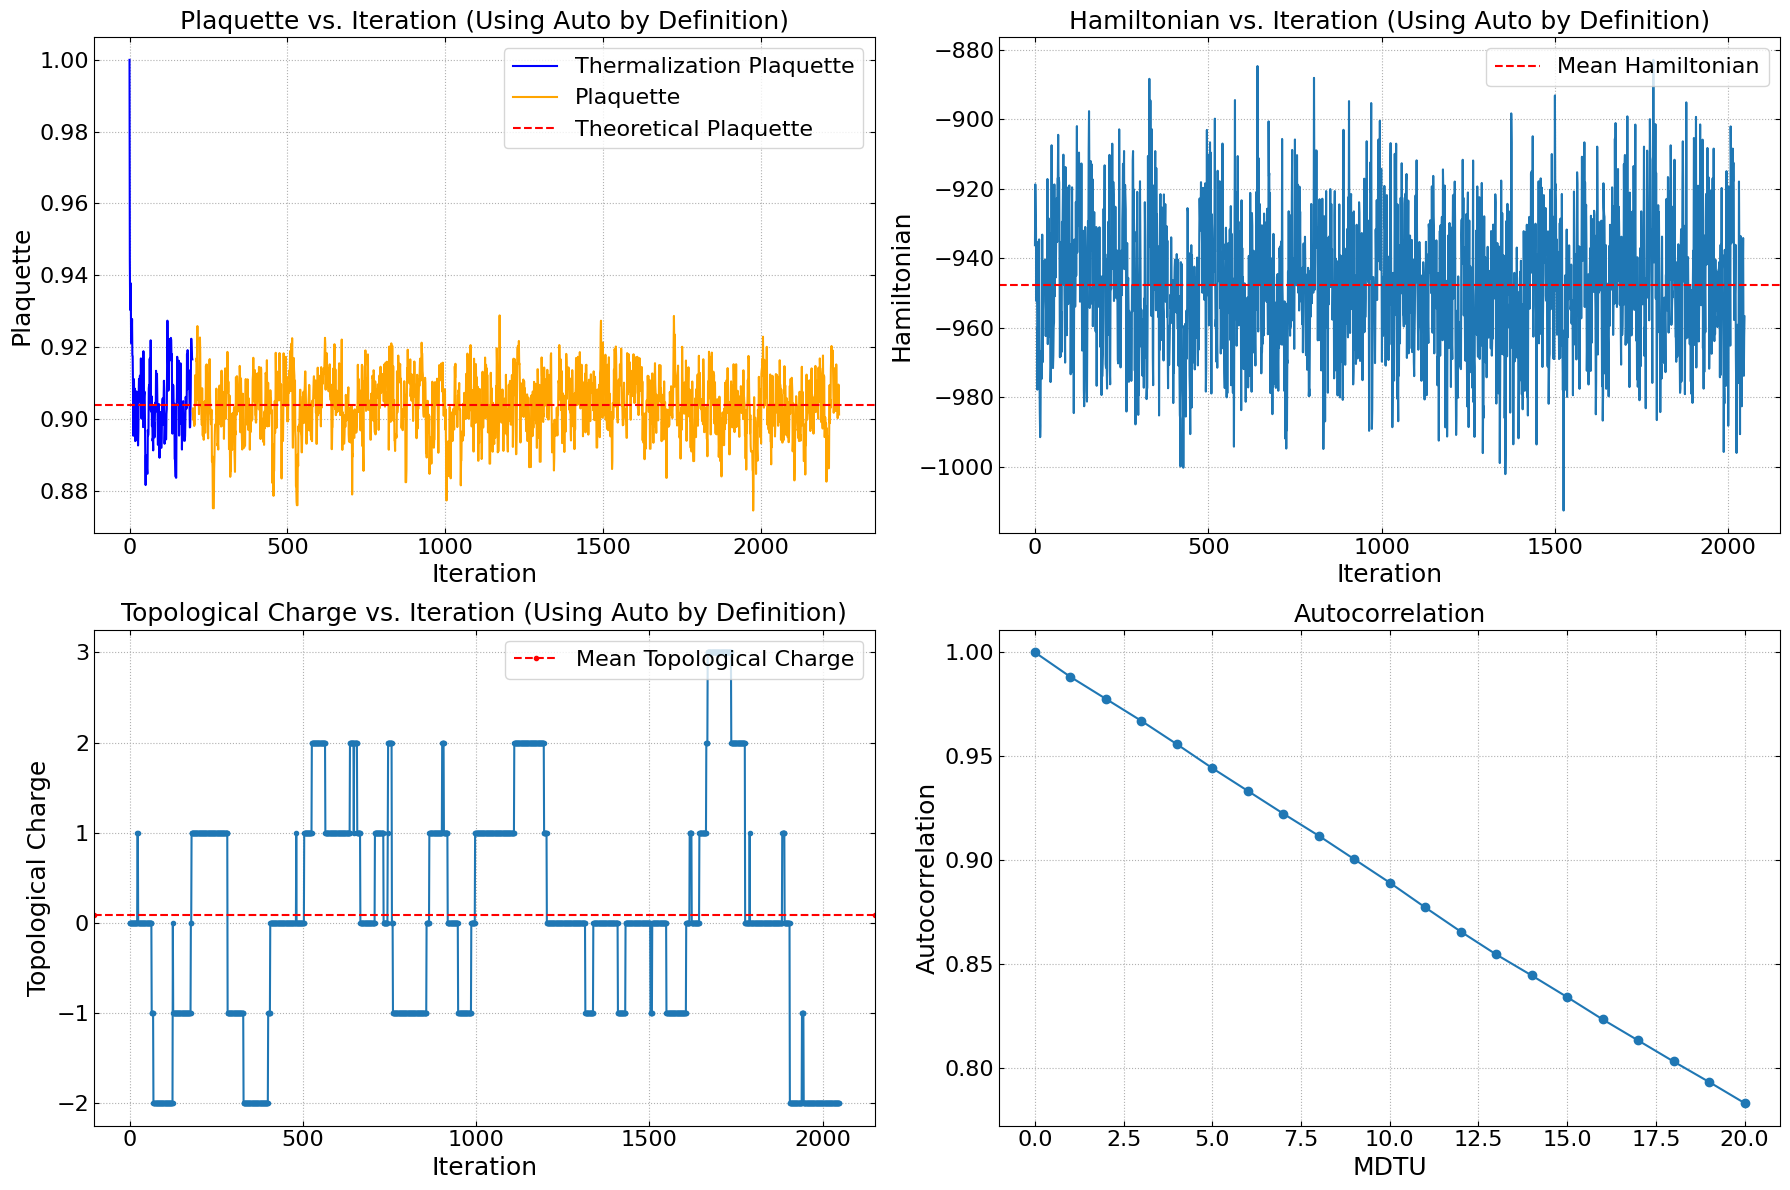

>>> Theoretical plaquette:  0.9038174337574352
>>> Mean plaq:  0.9036403331556357
>>> Std of mean plaq:  0.00018127860657908012
Thermalization acceptance rate: 0.9050
Acceptance rate: 0.8638


In [4]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# initialize the field transformation
nn_ft = FieldTransformation(lattice_size, device=device, n_subsets=8)
# nn_ft.model.load_state_dict(torch.load('models/cnn_save.pt'), weights_only=False)

# load the data
data = np.load('dump/theta_ori.npy')
tensor_data = torch.from_numpy(data).float().to(device)
print(f"Loaded data shape: {tensor_data.shape}")

# split the data into training and testing
train_size = int(0.8 * len(tensor_data))
train_data = tensor_data[:train_size]
test_data = tensor_data[train_size:]
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# train the model
print(">>> Training the model")
nn_ft.train(train_data, test_data, beta, n_epochs=16, batch_size=16)

# Save the trained models
print(">>> Saving the trained models")
save_dict = {}
for i, model in enumerate(nn_ft.models):
    save_dict[f'model_{i}'] = model.state_dict()
torch.save(save_dict, 'models/cnn_trained.pt')
print(">>> Models saved successfully")

# Load the trained models
print(">>> Loading the trained models")
saved_models = torch.load('models/cnn_trained.pt')
for i, model in enumerate(nn_ft.models):
    model.load_state_dict(saved_models[f'model_{i}'])
    model.eval()
print(">>> Models loaded successfully")


field_transformation = nn_ft.field_transformation
compute_jac_logdet = nn_ft.compute_jac_logdet

# Initialize HMC with field transformation
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=field_transformation, compute_jac_logdet=compute_jac_logdet, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)